In [1]:
import torch
from torch.utils.data import random_split
from torch_geometric.data import DataLoader
from torch_geometric.datasets import MoleculeNet
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw

# Load the ESOL dataset
dataset = MoleculeNet(root="data/MoleculeNet", name="ESOL")
print(dataset)


ESOL(1128)


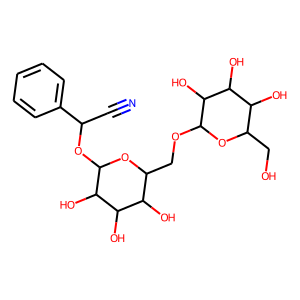

In [2]:
# Convert a molecule from the dataset to an RDKit object and visualize
mol = Chem.MolFromSmiles(dataset[0].smiles)
Draw.MolToImage(mol)

In [3]:
type(mol)

rdkit.Chem.rdchem.Mol

In [4]:
class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x.float(), data.edge_index.long()
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, data.batch)
        return x

model = GNN(input_dim=dataset.num_node_features, hidden_dim=64, output_dim=1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


print(device)

cpu


In [5]:
# Split the data into 80 training and 20 testing
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# DataLoader for training and testing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


C:\Users\clvkr\anaconda3\envs\my-rdkit-env\lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [6]:
# Train the model
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

model.train()
train_losses = []
for epoch in range(1000):
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data).squeeze(1)
        loss = criterion(output, data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    epoch_loss = total_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}, Loss: {epoch_loss}')


C:\Users\clvkr\anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\clvkr\anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Loss: 20.44524380163098
Epoch 101, Loss: 4.409107871089422
Epoch 201, Loss: 4.398800968278384
Epoch 301, Loss: 4.411430903360353
Epoch 401, Loss: 4.404942722185283
Epoch 501, Loss: 4.420830790878187
Epoch 601, Loss: 4.401240592307233
Epoch 701, Loss: 4.402016521345639
Epoch 801, Loss: 4.393988619459436
Epoch 901, Loss: 4.422706377421711


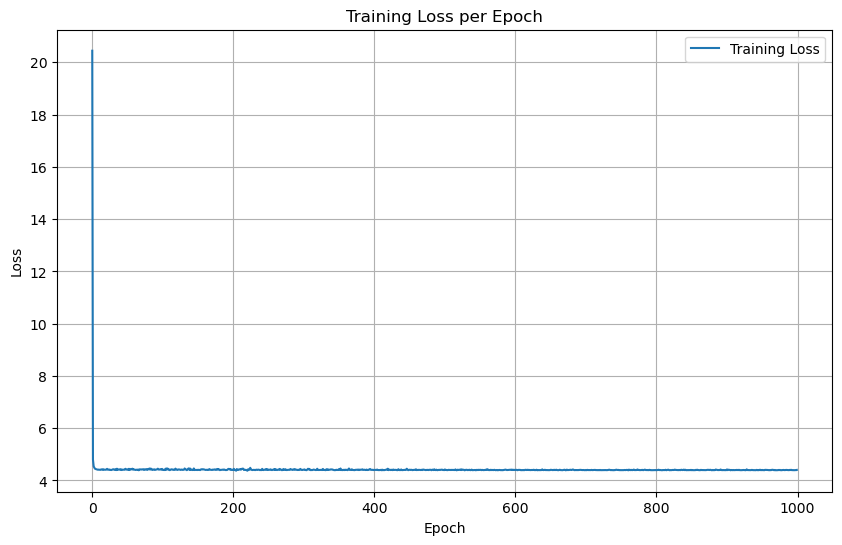

In [7]:
# Plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# Evaluate the model on the test set
model.eval()
test_loss = 0
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        output = model(data).squeeze(1)
        loss = criterion(output, data.y.float())
        test_loss += loss.item() * data.num_graphs
test_loss /= len(test_loader.dataset)
print(f'Test Loss: {test_loss}')


Test Loss: 3.7905295338250893


C:\Users\clvkr\anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([2, 1])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
